In [14]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [225]:
!nvidia-smi

Thu Nov 25 21:04:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    36W / 250W |   8783MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [226]:
!ln -s /content/gdrive/My\ Drive/ /mydrive

ln: failed to create symbolic link '/mydrive/My Drive': File exists


In [227]:
%cd /mydrive/Multi-label\ Classification/FITW

/content/gdrive/My Drive/Multi-label Classification/FITW


In [228]:
!ls

enh	  Enhanced.csv	Raw	 ResNet50.ipynb  VGG19.ipynb
Enhanced  raw		Raw.csv  VGG16.ipynb	 Xception.ipynb


## 1. Preprocessing

In [229]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
import pandas as pd
import pathlib, datetime

In [230]:
df=pd.read_csv("Raw.csv")
df.columns = df.columns.str.replace(' ','')
df.head()

,filename,Rockfish,Starfish,Tilefish
0,2--6----Copy_jpg.rf.f98d10b8ed8511d0d1f52b56f6...,0,0,1
1,Set2_DSCN1438-JPG_0---Copy_jpg.rf.fa090bff4d1b...,1,1,0
2,x3---Copy_bmp.rf.fa388522a25169dd7fdd3efa08f76...,0,1,0
3,dddd_bmp.rf.fac67cf27ddc05937c053e6a06d491bf.jpg,0,1,0
4,49--6-_bmp.rf.fc7ef0036ddf451ecf97987a3c3cf10f...,0,0,1


In [231]:
#df[['filename','Rockfish', 'Starfish', 'Tilefish']].groupby(['Rockfish', 'Starfish', 'Tilefish']).agg(['count'])


In [232]:
LABELS=["Rockfish", "Starfish", "Tilefish"]

In [233]:
data_dir = pathlib.Path("Raw")
filenames = list(data_dir.glob('*.jpg'))
fnames=[]
for fname in filenames:
  fnames.append(str(fname))

print(len(fnames))


767


In [234]:
ds_size= len(fnames)
print("Number of images in folders: ", ds_size)

number_of_selected_samples=2000
filelist_ds = tf.data.Dataset.from_tensor_slices(fnames[:number_of_selected_samples])

ds_size= filelist_ds.cardinality().numpy()
print("Number of selected samples for dataset: ", ds_size)

Number of images in folders:  767
Number of selected samples for dataset:  767


In [235]:
def get_label(file_path):
  parts = tf.strings.split(file_path, '/')
  file_name= parts[-1]
  labels= df[df["filename"]==file_name][LABELS].to_numpy().squeeze()
  return tf.convert_to_tensor(labels)

In [236]:
IMG_WIDTH, IMG_HEIGHT = 256 , 256
def decode_img(img):
  #color images
  img = tf.image.decode_jpeg(img, channels=3) 
  #convert unit8 tensor to floats in the [0,1]range
  img = tf.image.convert_image_dtype(img, tf.float32) 
  #resize 
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT]) 

In [237]:
def combine_images_labels(file_path: tf.Tensor):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [238]:
train_ratio = 0.70
ds_train=filelist_ds.take(ds_size*train_ratio)
ds_test=filelist_ds.skip(ds_size*train_ratio)

In [239]:
BATCH_SIZE= 64

In [240]:
ds_train=ds_train.map(lambda x: tf.py_function(func=combine_images_labels,
          inp=[x], Tout=(tf.float32,tf.int64)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=False)

In [241]:
ds_test= ds_test.map(lambda x: tf.py_function(func=combine_images_labels,
          inp=[x], Tout=(tf.float32,tf.int64)),
          num_parallel_calls=tf.data.AUTOTUNE,
          deterministic=False)

In [242]:
ds_test

<ParallelMapDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int64)>

In [243]:
def covert_onehot_string_labels(label_string,label_onehot):
  labels=[]
  for i, label in  enumerate(label_string):
     if label_onehot[i]:
       labels.append(label)
  if len(labels)==0:
    labels.append("NONE")
  return labels

9 samples from the dataset


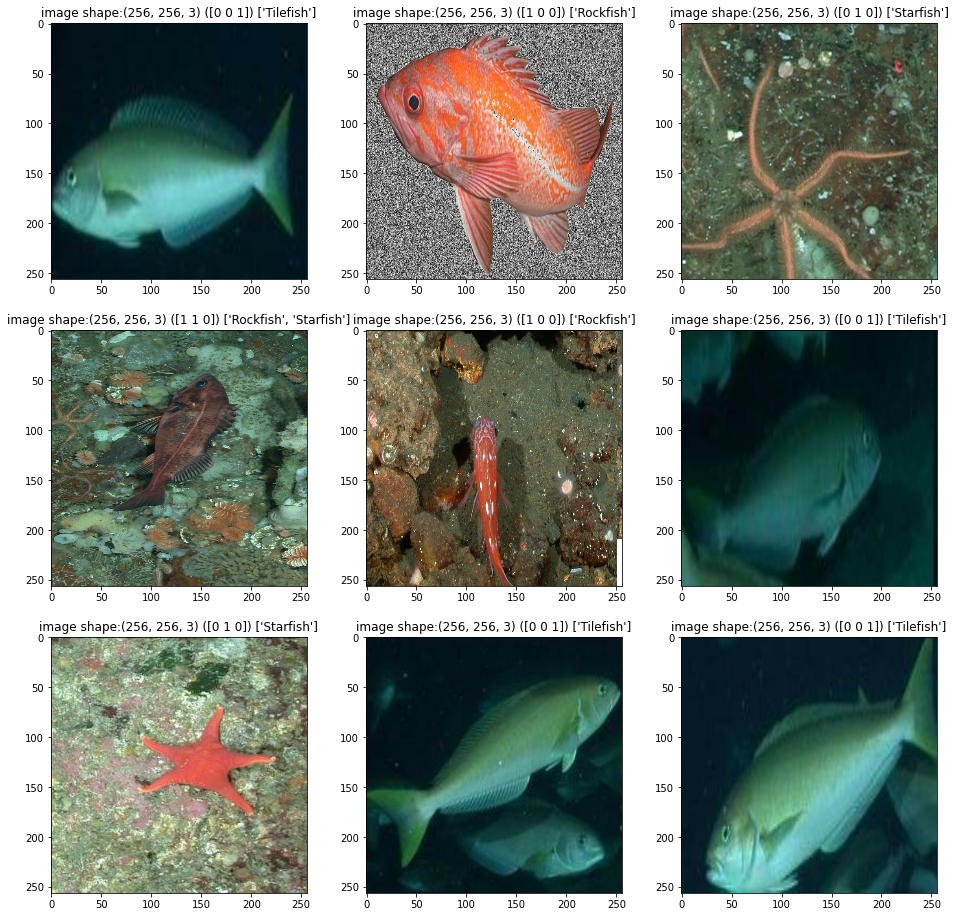

In [244]:
def show_samples(dataset):
  fig=plt.figure(figsize=(16, 16))
  columns = 3
  rows = 3
  print(columns*rows,"samples from the dataset")
  i=1
  for a,b in dataset.take(columns*rows): 
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(a))
    plt.title("image shape:"+ str(a.shape)+" ("+str(b.numpy()) +") "+ 
              str(covert_onehot_string_labels(LABELS,b.numpy())))
    i=i+1
  plt.show()
show_samples(ds_test)

In [245]:
#buffer_size = ds_train_resize_scale.cardinality().numpy()/10
#ds_resize_scale_batched=ds_raw.repeat(3).shuffle(buffer_size=buffer_size).batch(64, )

ds_train_batched=ds_train.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE) 
ds_test_batched=ds_test.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE)

print("Number of batches in train: ", ds_train_batched.cardinality().numpy())
print("Number of batches in test: ", ds_test_batched.cardinality().numpy())


Number of batches in train:  9
Number of batches in test:  4


## 2. Create a Keras CNN model by using Transfer learning

In [246]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256 , 256 , 3), #  expects min 32 x 32
    include_top=False)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False

In [247]:
number_of_classes = 3

In [248]:
inputs = keras.Input(shape=(256 , 256 , 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
initializer = tf.keras.initializers.GlorotUniform(seed=42)

activation =  tf.keras.activations.sigmoid #None  # tf.keras.activations.sigmoid or softmax

outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(x) 
model = keras.Model(inputs, outputs)

In [249]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(), # default from_logits=False
              metrics=[keras.metrics.BinaryAccuracy()])

In [250]:
history = model.fit(ds_train_batched, validation_data=ds_test_batched, epochs=1000)

Epoch 1/1000
9/9 [==============================] - 105s 12s/step - loss: 0.5905 - binary_accuracy: 0.7139 - val_loss: 0.4464 - val_binary_accuracy: 0.8629
Epoch 2/1000
9/9 [==============================] - 2s 240ms/step - loss: 0.3729 - binary_accuracy: 0.9061 - val_loss: 0.3164 - val_binary_accuracy: 0.9322
Epoch 3/1000
9/9 [==============================] - 2s 240ms/step - loss: 0.2658 - binary_accuracy: 0.9490 - val_loss: 0.2511 - val_binary_accuracy: 0.9394
Epoch 4/1000
9/9 [==============================] - 2s 239ms/step - loss: 0.2113 - binary_accuracy: 0.9571 - val_loss: 0.2171 - val_binary_accuracy: 0.9380
Epoch 5/1000
9/9 [==============================] - 2s 239ms/step - loss: 0.1819 - binary_accuracy: 0.9596 - val_loss: 0.1992 - val_binary_accuracy: 0.9452
Epoch 6/1000
9/9 [==============================] - 2s 240ms/step - loss: 0.1633 - binary_accuracy: 0.9633 - val_loss: 0.1875 - val_binary_accuracy: 0.9452
Epoch 7/1000
9/9 [==============================] - 2s 240ms/ste

### Evaulate the model

In [251]:
ds= ds_test_batched
print("Test Accuracy: ", model.evaluate(ds)[1])

4/4 [==============================] - 1s 152ms/step - loss: 0.2426 - binary_accuracy: 0.9711
Test Accuracy:  0.9711400270462036


In [252]:
ds=ds_test
predictions= model.predict(ds.batch(batch_size=10).take(1))
print("A sample output from the last layer (model) ", predictions[0])
y=[]
print("10 Sample predictions:")
for (pred,(a,b)) in zip(predictions,ds.take(10)):
  
  pred[pred>0.5]=1
  pred[pred<=0.5]=0
  print("predicted: " ,pred, str(covert_onehot_string_labels(LABELS, pred)),  
        "Actual Label: ("+str(covert_onehot_string_labels(LABELS,b.numpy())) +")")
  y.append(b.numpy())

A sample output from the last layer (model)  [1.2861082e-06 1.0361489e-06 1.0000000e+00]
10 Sample predictions:
predicted:  [0. 0. 1.] ['Tilefish'] Actual Label: (['Tilefish'])
predicted:  [1. 0. 0.] ['Rockfish'] Actual Label: (['Starfish'])
predicted:  [1. 1. 0.] ['Rockfish', 'Starfish'] Actual Label: (['Rockfish'])
predicted:  [0. 1. 0.] ['Starfish'] Actual Label: (['Rockfish', 'Starfish'])
predicted:  [0. 0. 1.] ['Tilefish'] Actual Label: (['Tilefish'])
predicted:  [1. 0. 0.] ['Rockfish'] Actual Label: (['Rockfish'])
predicted:  [0. 1. 0.] ['Starfish'] Actual Label: (['Starfish'])
predicted:  [0. 0. 1.] ['Tilefish'] Actual Label: (['Tilefish'])
predicted:  [0. 0. 1.] ['Tilefish'] Actual Label: (['Tilefish'])
predicted:  [0. 0. 1.] ['Tilefish'] Actual Label: (['Tilefish'])


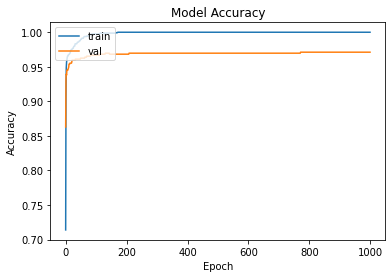

In [253]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('raw/Accuracy_Exp1.png', dpi=1200)
plt.show()

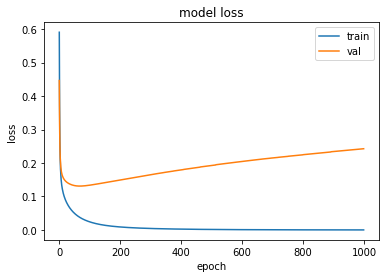

In [254]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig('raw/Loss_Exp1.png', dpi=1200)
plt.show()

In [ ]:
!ls

enh  Enhanced  Enhanced.csv  raw  Raw  Raw.csv	VGG16.ipynb  VGG19.ipynb
